In [1]:
from IPython.core.display import HTML, display
HTML("""<style>.container { width:100% !important; } div.output_area {overflow-y: scroll;} div.output_area img {max-width: unset;} </style>""")

In [2]:
import pandas as pd
import numpy as np
from math import floor, ceil
import eli5 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

from feature_extraction import get_adaptive_spike_count, get_spike_count
from machine_learning import * 
from importers import SpikeImporter
from feature_extraction import calc_dist_to_prev_reg_el_stimulus

/Users/Radomir/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Radomir/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### Extract AP data

In [3]:
data_folder = "../data/"
file_name = '20_05_13_U1a_4960s_5400s'#"20_05_13_U1a_complete"
file_ending = ".csv"

time_channel = "Time"
signal_channel = "1 Signal"
stimulus_channel = "32 DigMark"
ap_marker_channels = ["3 nw-1"]
extra_stimuli_channel = "801 DigMark"

# load the animal file
importer = SpikeImporter(filepath = data_folder + file_name + file_ending, time_channel = time_channel, signal_channel = signal_channel)
max_gap_time = 0.005
el_stimuli = importer.get_electrical_stimuli(regular_stimulus_channel = stimulus_channel)
el_extra_stimuli = importer.get_extra_stimuli(extra_stimulus_channel = extra_stimuli_channel, regular_el_stimuli = el_stimuli, verbose = False)
actpots = importer.get_action_potentials(ap_marker_channels = ap_marker_channels, verbose = False)
raw_signal = importer.get_raw_signal_split_by_stimuli(el_stimuli = el_stimuli, verbose = False)

for ap in actpots:
    ap.features["spikecount"] = get_adaptive_spike_count(actpot = ap, actpots = actpots, timeframe = 1600, num_splits = 16)
    ap.features["latency"], ap.prev_stimuli["regular"] = calc_dist_to_prev_reg_el_stimulus(ap, el_stimuli)
    
#candidate_aps = [ap for ap in actpots if ap.implied_fibre_index == 0]

List of eletrical stimuli created.
List of extra eletrical stimuli created.
Finished processing AP channel 1 out of 1
List of APs created.
Done with cropping the intervals


### Data analysis

There are 227 action potentials.


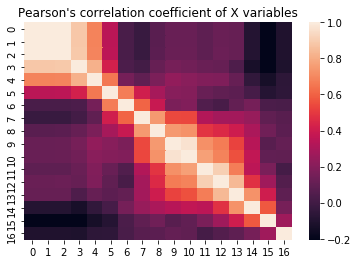

In [4]:
heatmap = sns.heatmap(np.array(pd.DataFrame([ap.features['spikecount'] for ap in actpots]).corr()))
heatmap.set_title("Pearson's correlation coefficient of X variables")
print(f'There are {len(actpots)} action potentials.')

We can observe time dependence via correlation graph of independent variables.

### Perform evaluation

In [5]:
eval_dict = {'Overfitting check': [], 'Accuracy check': [], 'Homoscedascity check': []}
model = LinearRegression()
overfitting_metric = mean_squared_error
accuracy_metric = r2_score
test_percentage = 0.25
splitting_method = timebased_train_test_split  # Change this to primitive_split to see the difference

for i in range(0, 100):
    
    train_aps, test_aps = splitting_method(actpots, test_percentage = test_percentage, num_test_intervals = 10)
    X_train = [ap.features["spikecount"] for ap in train_aps]
    y_train = [ap.features["latency"] for ap in train_aps]
    X_test = [ap.features["spikecount"] for ap in test_aps]
    y_test = [ap.features["latency"] for ap in test_aps]
    
    fitted_model = model.fit(X = X_train, y = y_train)
    eval_dict['Overfitting check'].append(overfit_check(X_train, X_test, y_train, y_test, fitted_model, overfitting_metric))
    eval_dict['Accuracy check'].append(accuracy_check(X_train, X_test, y_train, y_test, fitted_model, accuracy_metric))
    eval_dict['Homoscedascity check'].append(homoscedascity_check(X_train, X_test, y_train, y_test, fitted_model))

### Plot evaluation

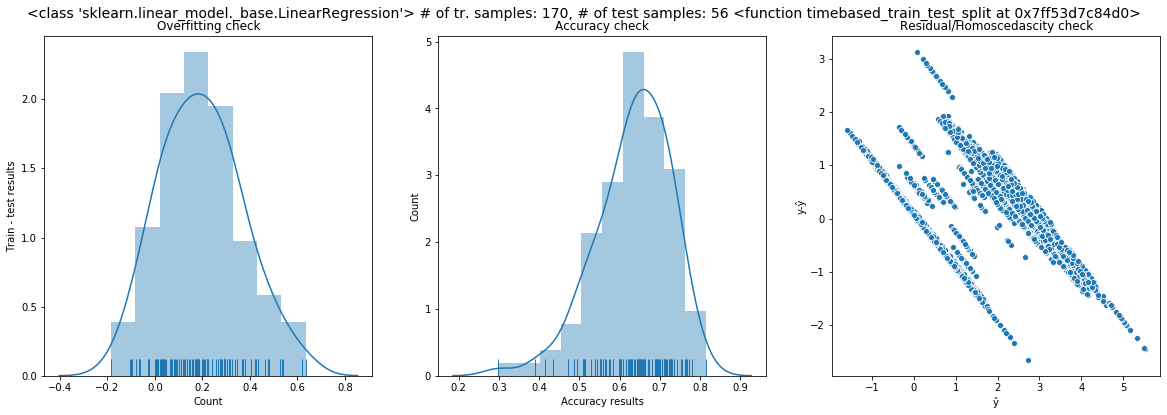

In [6]:
fig, axs = plt.subplots(1, len(eval_dict), figsize=(20, 4))
plt.subplots_adjust(bottom=-0.3)
plt.suptitle(f"{type(model)} # of tr. samples: {floor(len(actpots)*(1-test_percentage))}, # of test samples: {floor(len(actpots)*test_percentage)} {splitting_method}", fontsize=14)

for i, column in enumerate(eval_dict):
    
    if column == 'Homoscedascity check':
        reshaped_arr = np.array(eval_dict[column]).reshape(-1, 2)
        _ = sns.scatterplot(x=reshaped_arr[:, 0], y=reshaped_arr[:, 1], ax=axs[i])
        axs[i].set_title('Residual/Homoscedascity check')
        axs[i].set_xlabel('ŷ')
        axs[i].set_ylabel('y-ŷ')
    elif column == 'Overfitting check':
        _ = sns.distplot(eval_dict[column], ax=axs[i], rug=True)
        axs[i].set_title(column)
        axs[i].set_xlabel('Count')
        axs[i].set_ylabel('Train - test results')
    else:
        _ = sns.distplot(eval_dict[column], ax=axs[i], rug=True)
        axs[i].set_title(column)
        axs[i].set_xlabel('Accuracy results')
        axs[i].set_ylabel('Count')

### Feature importance

In [7]:
# Taking the last fitted model as an example
eli5.show_weights(fitted_model)

Weight?,Feature
+1.161,<BIAS>
+0.623,x9
+0.601,x11
+0.274,x12
+0.172,x16
+0.168,x15
+0.031,x5
+0.020,x0
+0.020,x1
+0.016,x14
